# Parent-Child Emotion-Condition Sweep
Train adult + child agents across all emotion observation conditions (full, self, other, none), store their artifacts, and compare the guided children during training and evaluation.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import json
import sys
import torch
from omegaconf import OmegaConf

REPO_ROOT = Path.cwd()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from sorrel.action.action_spec import ActionSpec
from sorrel.models.pytorch.iqn import iRainbowModel
from sorrel.examples.leakyemotions.entities import EmptyEntity
from sorrel.examples.leakyemotions.world import LeakyEmotionsWorld
from sorrel.examples.leakyemotions.env import LeakyEmotionsEnv
from sorrel.examples.leakyemotions.agents import LeakyEmotionsAgent
from sorrel.examples.leakyemotions.custom_observation_spec import (
    LeakyEmotionsObservationSpec,
    InteroceptiveObservationSpec,
    OtherOnlyObservationSpec,
    NoEmotionObservationSpec,
)
from sorrel.utils.logging import JupyterLogger
from sorrel.utils.visualization import ImageRenderer

plt.style.use('ggplot')


In [12]:
CONFIG_PATH = Path('sorrel/examples/leakyemotions/configs/default.yaml')

ADULT_EPOCHS = 1000
CHILD_EPOCHS = 700
CHILD_COUNT = 3
EVAL_EPOCHS = 400
EMOTION_CONDITIONS = ['full', 'self', 'other', 'none']

base_config = OmegaConf.load(CONFIG_PATH)
base_config.experiment.epochs = ADULT_EPOCHS
base_config.experiment.max_turns = 40
base_config.experiment.record_period = 50
base_config.experiment.zero_emotion_after_training = False
base_config.experiment.zero_emotion_eval_epochs = 0
base_config.model.agent_vision_radius = 3
base_config.world.agents = 6
base_config.world.wolves = 0


In [13]:
RUN_LABEL = 'emotion_condition_sweep'  # Update between runs
RUNS_ROOT = Path('runs_parent_child')
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
RUN_DIR = RUNS_ROOT / f'{timestamp}_{RUN_LABEL}'
RUN_DIR.mkdir(parents=True, exist_ok=True)
print(f'Artifacts for this sweep will be stored in {RUN_DIR}')


Artifacts for this sweep will be stored in runs_parent_child/20251203-114022_emotion_condition_sweep


In [14]:
ENTITY_LIST = ['EmptyEntity', 'Bush', 'Wall', 'Grass', 'LeakyEmotionsAgent', 'Wolf']

def clone_config(cfg):
    return OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))

def build_observation_spec(condition: str, vision_radius: int):
    if condition == 'full':
        spec = LeakyEmotionsObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    elif condition == 'self':
        spec = InteroceptiveObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    elif condition == 'other':
        spec = OtherOnlyObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    else:
        spec = NoEmotionObservationSpec(ENTITY_LIST, full_view=False, vision_radius=vision_radius)
    spec.override_input_size(np.zeros(spec.input_size, dtype=int).reshape(1, -1).shape)
    return spec

def create_untrained_agent(cfg) -> LeakyEmotionsAgent:
    observation_spec = build_observation_spec(cfg.model.emotion_condition, cfg.model.agent_vision_radius)
    action_spec = ActionSpec(['up', 'down', 'left', 'right'])
    model = iRainbowModel(
        input_size=observation_spec.input_size,
        action_space=action_spec.n_actions,
        layer_size=250,
        epsilon=0.05,
        device='cpu',
        seed=torch.random.seed(),
        n_frames=5,
        n_step=3,
        sync_freq=200,
        model_update_freq=4,
        batch_size=64,
        memory_size=1024,
        LR=0.00025,
        TAU=0.001,
        GAMMA=0.99,
        n_quantiles=12,
    )
    return LeakyEmotionsAgent(observation_spec=observation_spec, action_spec=action_spec, model=model)

def freeze_agent_models(agent_list):
    for agent in agent_list:
        model = agent.model
        if hasattr(model, 'eval'):
            model.eval()
        parameters = getattr(model, 'parameters', None)
        if callable(parameters):
            for param in parameters():
                if hasattr(param, 'requires_grad_'):
                    param.requires_grad_(False)

def run_child_training(env: LeakyEmotionsEnv, child_agents: list, epochs: int, logger: JupyterLogger | None,
                       animate: bool = False, output_dir: Path | None = None) -> None:
    assert child_agents, 'child_agents list cannot be empty'
    max_turns = env.config.experiment.max_turns
    record_period = env.config.experiment.record_period
    epsilon_decay = getattr(env.config.model, 'epsilon_decay', 0.0)
    renderer = None
    if animate:
        if output_dir is None:
            output_dir = Path('animations')
        output_dir.mkdir(parents=True, exist_ok=True)
        renderer = ImageRenderer(
            experiment_name=env.world.__class__.__name__,
            record_period=record_period,
            num_turns=max_turns,
        )
    for epoch in range(epochs + 1):
        env.reset()
        for agent in env.agents:
            agent.model.start_epoch_action(epoch=epoch)
        animate_this_turn = animate and (epoch % record_period == 0)
        bunnies_left = sum(agent.alive for agent in env.bunnies)
        while env.turn < max_turns and bunnies_left > 0:
            if animate_this_turn and renderer is not None:
                renderer.add_image(env.world)
            env.take_turn()
            bunnies_left = sum(agent.alive for agent in env.bunnies)
        env.world.is_done = True
        if animate_this_turn and renderer is not None:
            renderer.save_gif(epoch, output_dir)
        total_loss = 0.0
        for agent in child_agents:
            loss = agent.model.train_step()
            total_loss += loss
            agent.model.epsilon_decay(epsilon_decay)
        if logger is not None:
            logger.record_turn(epoch, total_loss, env.world.total_reward, child_agents[0].model.epsilon)

def run_evaluation(env: LeakyEmotionsEnv, epochs: int) -> np.ndarray:
    rewards = []
    previous_modes = []
    for agent in env.agents:
        model = agent.model
        previous_modes.append(getattr(model, 'training', False))
        if hasattr(model, 'eval'):
            model.eval()
    for epoch in range(epochs):
        env.reset()
        for agent in env.agents:
            agent.model.start_epoch_action(epoch=epoch)
        bunnies_left = sum(agent.alive for agent in env.bunnies)
        while env.turn < env.config.experiment.max_turns and bunnies_left > 0:
            env.take_turn()
            bunnies_left = sum(agent.alive for agent in env.bunnies)
        env.world.is_done = True
        rewards.append(env.world.total_reward)
    for agent, mode in zip(env.agents, previous_modes):
        if hasattr(agent.model, 'train'):
            agent.model.train(mode=mode)
    return np.array(rewards)


In [15]:
condition_summaries = []
training_curves = {}
evaluation_curves = {}

for condition in EMOTION_CONDITIONS:
    print(f'=== Emotion condition: {condition} ===')
    cfg = clone_config(base_config)
    cfg.model.emotion_condition = condition
    world = LeakyEmotionsWorld(config=cfg, default_entity=EmptyEntity())
    env = LeakyEmotionsEnv(world, cfg)

    condition_dir = RUN_DIR / condition
    condition_dir.mkdir(parents=True, exist_ok=True)
    animations_dir = condition_dir / 'animations'
    animations_dir.mkdir(parents=True, exist_ok=True)

    adult_logger = JupyterLogger(max_epochs=ADULT_EPOCHS + 1)
    adult_anim_dir = animations_dir / 'adult'
    adult_anim_dir.mkdir(parents=True, exist_ok=True)
    env.run_experiment(animate=True, logger=adult_logger, output_dir=adult_anim_dir)
    adult_rewards = np.array(adult_logger.rewards)
    np.save(condition_dir / 'adult_training_rewards.npy', adult_rewards)
    adult_logger.to_csv(condition_dir / 'adult_training_log.csv')

    adult_agents = list(env.agents)
    freeze_agent_models(adult_agents)

    child_agents = [create_untrained_agent(cfg) for _ in range(CHILD_COUNT)]
    for child in child_agents:
        child.model.train()
        env.agents.append(child)
        env.bunnies.append(child)
    cfg.world.agents = len(env.agents)

    cfg.experiment.epochs = CHILD_EPOCHS
    child_logger = JupyterLogger(max_epochs=CHILD_EPOCHS + 1)
    guided_anim_dir = animations_dir / 'guided_children'
    guided_anim_dir.mkdir(parents=True, exist_ok=True)
    run_child_training(env, child_agents, CHILD_EPOCHS, child_logger, animate=True, output_dir=guided_anim_dir)
    guided_rewards = np.array(child_logger.rewards)
    np.save(condition_dir / 'guided_child_training_rewards.npy', guided_rewards)
    child_logger.to_csv(condition_dir / 'guided_child_training_log.csv')

    guided_eval = run_evaluation(env, epochs=EVAL_EPOCHS)
    np.save(condition_dir / 'guided_child_eval.npy', guided_eval)

    training_curves[condition] = guided_rewards
    evaluation_curves[condition] = guided_eval

    condition_summaries.append({
        'condition': condition,
        'training_final_reward': float(guided_rewards[-1]),
        'training_best_reward': float(np.max(guided_rewards)),
        'eval_avg_reward': float(np.mean(guided_eval)),
        'eval_std_reward': float(np.std(guided_eval)),
    })

summary_df = pd.DataFrame(condition_summaries)
display(summary_df)
summary_df.to_csv(RUN_DIR / 'emotion_condition_summary.csv', index=False)


╔══════════════╦══════════════╦══════════════╗
║ Epoch:   700 ║ Loss:    0.0 ║ Reward:76.13926576639638 ║
╚══════════════╩══════════════╩══════════════╝


,condition,training_final_reward,training_best_reward,eval_avg_reward,eval_std_reward
0,full,65.881880,156.354040,49.719220,29.345620
1,self,12.316284,154.570504,48.431370,32.137754
2,other,87.459309,153.776441,53.097311,29.810277
3,none,76.139266,207.666397,53.089368,34.756983


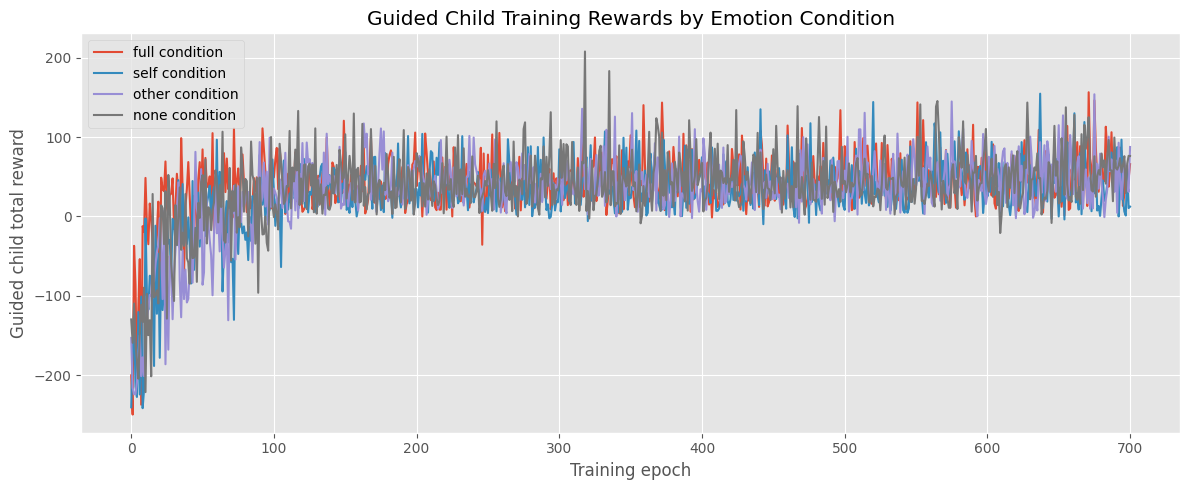

In [16]:
plt.figure(figsize=(12, 5))
for condition in EMOTION_CONDITIONS:
    rewards = training_curves.get(condition)
    if rewards is None:
        continue
    epochs = np.arange(len(rewards))
    plt.plot(epochs, rewards, label=f'{condition} condition')
plt.xlabel('Training epoch')
plt.ylabel('Guided child total reward')
plt.title('Guided Child Training Rewards by Emotion Condition')
plt.legend()
plt.tight_layout()
plt.savefig(RUN_DIR / 'guided_child_training_comparison.png', dpi=200)
plt.show()


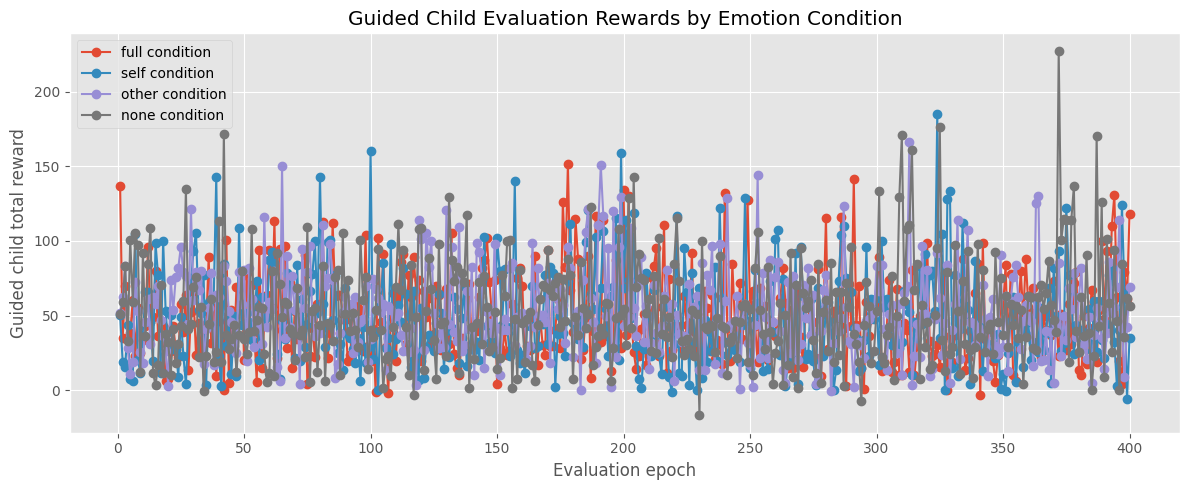

In [17]:
plt.figure(figsize=(12, 5))
eval_epochs = np.arange(1, EVAL_EPOCHS + 1)
for condition in EMOTION_CONDITIONS:
    rewards = evaluation_curves.get(condition)
    if rewards is None:
        continue
    plt.plot(eval_epochs, rewards, label=f'{condition} condition', marker='o')
plt.xlabel('Evaluation epoch')
plt.ylabel('Guided child total reward')
plt.title('Guided Child Evaluation Rewards by Emotion Condition')
plt.legend()
plt.tight_layout()
plt.savefig(RUN_DIR / 'guided_child_evaluation_comparison.png', dpi=200)
plt.show()
